In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)



Number of replicas: 1
2.13.1


In [72]:
GCS_PATH = r'C:\Users\David\Downloads\gan-getting-started'

# Problem Description

The goal of this project is to train a Generative Adversarial Network (GAN) in order to transfer the style of Monet from Monet paintings to photos. This will be achieved by creating a Generator which creates an image in the style of Monet (after training) while simultaneously creating a Discriminator which determines if the created image is in the style of Monet or not. 

The size of the data is 300 Monet paintings for style transfer training which will be applied to 7038 photos. There are 5 Monet TFRecord files and 20 Photo TFRecord files. 

# Exploratory Data Analysis

A TFRecord is a binary file format used primarily by TensorFlow for storing a sequence of binary records. It's optimized for use with TensorFlow for both training and inference purposes.

Below is the number of TFRecord files and model training and testing files

In [73]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [74]:
monet_training = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet Training Files:', len(monet_training))

photo_testing = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Photo Testing Files:', len(photo_testing))

Monet Training Files: 300
Photo Testing Files: 7038


In [75]:
# Function to read TFrecords and and decode images

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [76]:
# function to load datasets

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

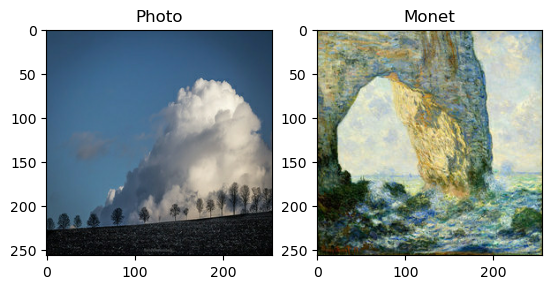

In [51]:
# Visualizing Monet Training Paintings and Photos

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Building the Generator

I'm going to create a generator using a UNET architecture for my CycleGAN project. Here’s how to build the generator by setting up methods for downsampling and upsampling.

Downsampling: This process shrinks the image's width and height. I achieve this by setting the stride to 2, which means the filter moves over every other pixel, effectively reducing the image’s size by half.

Upsampling: Upsampling increases the size of the image, making it larger than before. It does the reverse of what downsampling does. The tool I use for this, called Conv2DTranspose, works similarly to the usual Conv2D layer but in reverse, enlarging the image instead of reducing it.

I will also use a technique called instance normalization, which helps stabilize the learning process. Since TensorFlow doesn't have this built in, I will use a special layer available through TensorFlow Add-ons to apply it.

In [52]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [53]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

First, the generator makes the input image smaller through a process called downsampling. After that, it enlarges the image again using upsampling. Along the way, it uses something called skip connections. These connections help by linking earlier steps directly to later steps, which can make the generator work better and more efficiently. In this case, parts of the image that are shrunk are directly connected to parts where the image is enlarged again, creating a balanced structure.

In [54]:
# Building the Generator

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Building the Discriminator
The discriminator looks at an input image and decides whether it's real or fake (generated by our system). Instead of just saying 'yes' or 'no,' the discriminator gives a smaller image as its output. In this output image, high pixel values suggest the image is real, and low pixel values indicate it might be fake.

In [55]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [56]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

### Building the CycleGAN Model

I'll extend a tf.keras.Model, which allows me to use the fit() method to train our model later on. During training, the model will transform a regular photo into a Monet-style painting and then transform it back into a photo. The key measurement here is the cycle-consistency loss, which checks how similar the original photo is to the photo after it's been transformed twice. Our goal is to make these two photos as similar as possible.

In [57]:


class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Defining loss functions

Here's how the loss functions work in my CycleGAN model:

Discriminator Loss: This function evaluates how well the discriminator can distinguish between real images and fake (generated) images. It aims for the discriminator to recognize real images as 1s and fake images as 0s. The loss is calculated by taking the average of the losses from real images and generated images.

Generator Loss: The generator tries to trick the discriminator into believing that the images it creates are real. Ideally, the discriminator would identify all generated images as 1s. Therefore, the generator loss is determined by how closely the generated images can mimic real images, measured against a matrix of 1s.

Cycle Consistency Loss: For the images that have been transformed twice—first into the style of Monet's paintings and then back into photos—we measure how much the final photo differs from the original. The goal is to minimize this difference, ensuring that the original and twice-transformed photos look very similar.

Identity Loss: This loss checks if the generator can accurately reproduce an input when it's supposed to. For example, if a photo generator is given a photo, it should output that same photo. The identity loss compares the original input with the output from the generator to assess accuracy.

In [58]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


## Training the CycleGAN

In [26]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    


with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [27]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 863s 3s/step - monet_gen_loss: 5.1114 - photo_gen_loss: 5.3153 - monet_disc_loss: 0.6578 - photo_disc_loss: 0.6212
Epoch 2/25
300/300 [==============================] - 770s 3s/step - monet_gen_loss: 3.6151 - photo_gen_loss: 3.7277 - monet_disc_loss: 0.6661 - photo_disc_loss: 0.6283
Epoch 3/25
300/300 [==============================] - 772s 3s/step - monet_gen_loss: 3.5295 - photo_gen_loss: 3.6733 - monet_disc_loss: 0.6514 - photo_disc_loss: 0.6174
Epoch 4/25
300/300 [==============================] - 814s 3s/step - monet_gen_loss: 3.4919 - photo_gen_loss: 3.5755 - monet_disc_loss: 0.6334 - photo_disc_loss: 0.6245
Epoch 5/25
300/300 [==============================] - 827s 3s/step - monet_gen_loss: 3.3856 - photo_gen_loss: 3.4541 - monet_disc_loss: 0.6258 - photo_disc_loss: 0.6247
Epoch 6/25
300/300 [==============================] - 777s 3s/step - monet_gen_loss: 3.2905 - photo_gen_loss: 3.3607 - monet_disc_loss: 0.6207 - photo_disc

### Visualizing Results

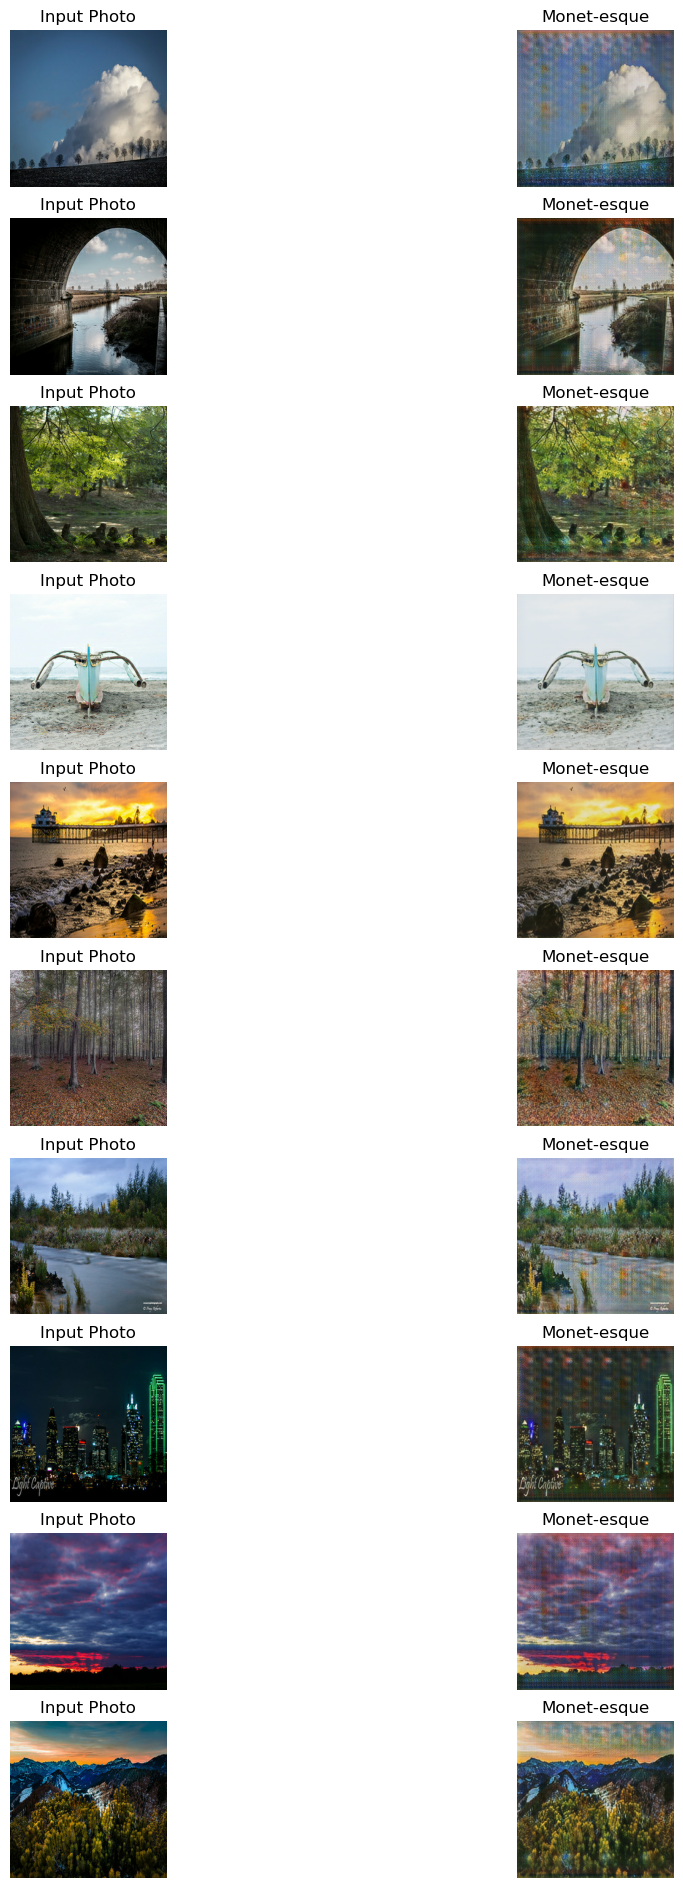

In [30]:
_, ax = plt.subplots(10, 2, figsize=(12, 24))  # Adjusted figsize to accommodate more rows
for i, img in enumerate(photo_ds.take(10)):  # Increased the loop to take 10 images
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


From the images, I can see that there appears to be artifacts for uniform colours such as skies and roads, and is best applied to greenery such as forests, trees, and woods. 

## Hyperparameter Tuning

In [43]:
#from tensorflow.keras.optimizers import SGD

#with strategy.scope():
#    monet_generator_optimizer = SGD(learning_rate=0.01, momentum=0.9)
#    photo_generator_optimizer = SGD(learning_rate=0.01, momentum=0.9)

#    monet_discriminator_optimizer = SGD(learning_rate=0.01, momentum=0.9)
#    photo_discriminator_optimizer = SGD(learning_rate=0.01, momentum=0.9)
    


#with strategy.scope():
#    tuned_cycle_gan_model = CycleGan(
#        monet_generator, photo_generator, monet_discriminator, photo_discriminator
#    )

#    tuned_cycle_gan_model.compile(
#        m_gen_optimizer = monet_generator_optimizer,
#        p_gen_optimizer = photo_generator_optimizer,
#        m_disc_optimizer = monet_discriminator_optimizer,
#        p_disc_optimizer = photo_discriminator_optimizer,
#        gen_loss_fn = generator_loss,
#        disc_loss_fn = discriminator_loss,
#        cycle_loss_fn = calc_cycle_loss,
#        identity_loss_fn = identity_loss
#    )

In [44]:
#tuned_cycle_gan_model.fit(
#    tf.data.Dataset.zip((monet_ds, photo_ds)),
#    epochs=5
#)

Epoch 1/5
     13/Unknown - 81s 2s/step - monet_gen_loss: nan - photo_gen_loss: nan - monet_disc_loss: 72822726587511209984.0000 - photo_disc_loss: nan                                                           

KeyboardInterrupt: 

In [80]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    


with strategy.scope():
    faster_cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    faster_cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [81]:
faster_cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 861s 3s/step - monet_gen_loss: 3.0503 - photo_gen_loss: 3.0411 - monet_disc_loss: 0.6265 - photo_disc_loss: 0.6380
Epoch 2/25
300/300 [==============================] - 798s 3s/step - monet_gen_loss: 3.0177 - photo_gen_loss: 2.9955 - monet_disc_loss: 0.6213 - photo_disc_loss: 0.6318
Epoch 3/25
300/300 [==============================] - 791s 3s/step - monet_gen_loss: 2.9799 - photo_gen_loss: 2.9636 - monet_disc_loss: 0.6198 - photo_disc_loss: 0.6275
Epoch 4/25
300/300 [==============================] - 789s 3s/step - monet_gen_loss: 2.9305 - photo_gen_loss: 2.9271 - monet_disc_loss: 0.6198 - photo_disc_loss: 0.6253
Epoch 5/25
300/300 [==============================] - 889s 3s/step - monet_gen_loss: 2.8917 - photo_gen_loss: 2.8931 - monet_disc_loss: 0.6171 - photo_disc_loss: 0.6220
Epoch 6/25
300/300 [==============================] - 891s 3s/step - monet_gen_loss: 2.8477 - photo_gen_loss: 2.8703 - monet_disc_loss: 0.6141 - photo_disc

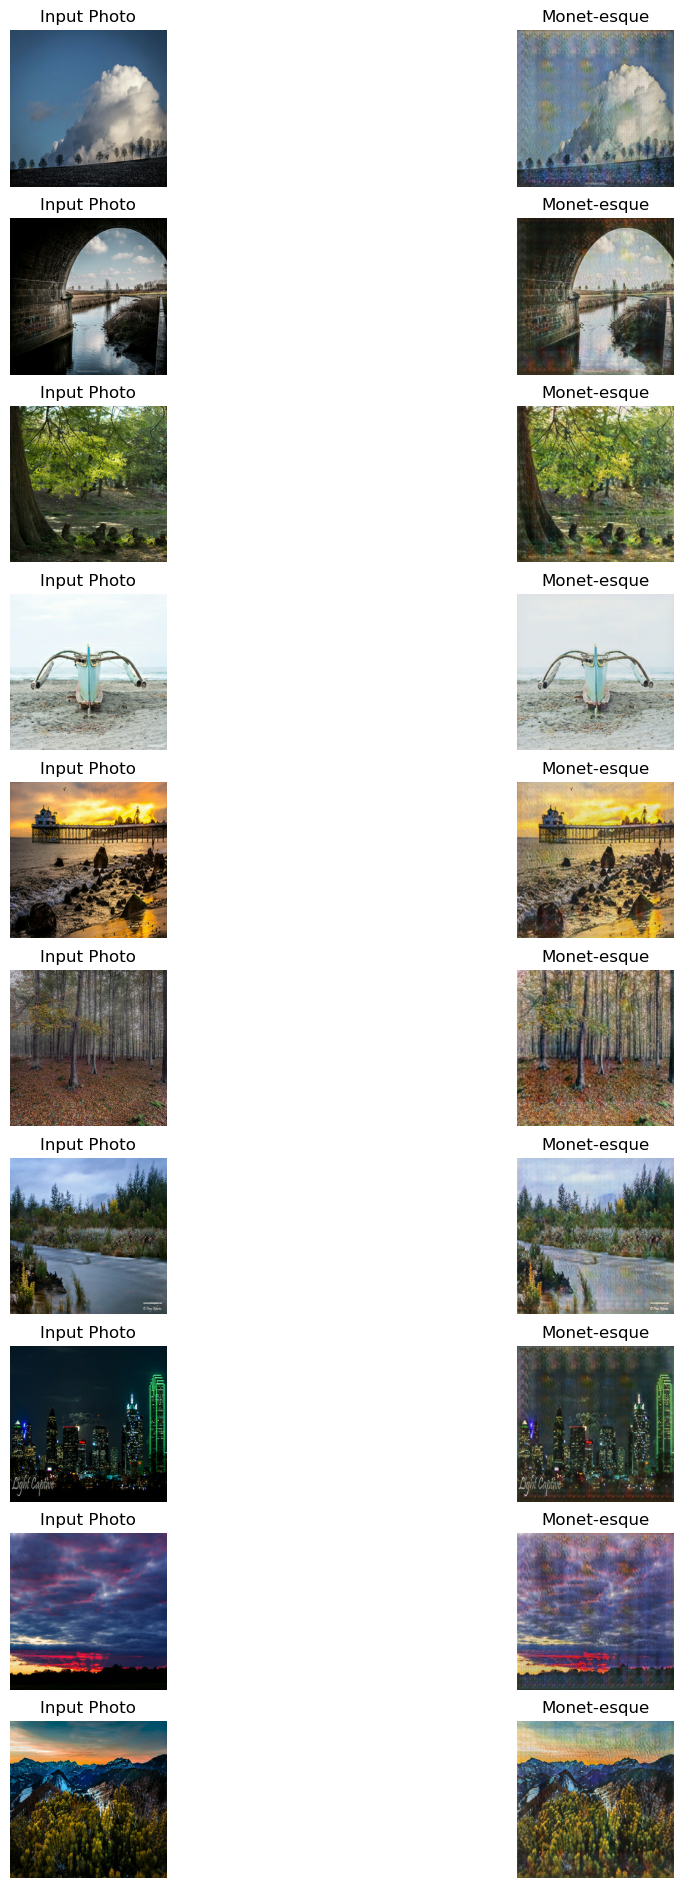

In [82]:
_, ax = plt.subplots(10, 2, figsize=(12, 24))  # Adjusted figsize to accommodate more rows
for i, img in enumerate(photo_ds.take(10)):  # Increased the loop to take 10 images
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


## Results

It looks like attempting to use a different optimizer such as stochastic gradient descent is completely inappropriate with loss increasing with each additional epoch. More research is needed on applying parameter and hyperparameter tuning to the example tutorial. I also tried increasing the learning rate which was able to achieve less loss with less iterations. The image quality of the monet styled photos are comparable with the loss at 5 epochs at learning rate of 3e-4 similar to 10 epochs at 2e-4. There is significantly less letterboxing as well. Overall, it looks like tuning the learning rate was a success. For the human eye, it seems like the style transfer was best applied to pictures involving trees, a gradient sunrise or sunset sky, and images with a lot of clutter (not a large slab of the same color). 


# Conclusion

A CycleGAN model was created following a tutorial on Kaggel from Amy Jang. Choosing a different optimizer can completely break the model, resulting with increasing loss per iteration. 

Training a CycleGAN takes significant time due to the presence of both a generator and discriminator neural network. Training GANs can be challenging due to the adversarial nature of the process. Issues such as mode collapse, where the generator learns to produce only a limited variety of outputs, and non-convergence, where the generator and discriminator do not stabilize, are common (this occurred in my project attempting to use an Stochastic Gradient Optimizer vs Adam. With enough computing resource, this can be an amazing tool for transfer learning in this case such as "the style of Monet".

Potential improvements to GANs can be using conditional GANs which have been developed to direct the generation process using labels or other forms of guidance. For example, it seems this CycleGAN performs well on nature photos but not on urban photos. If there is a gradient in the sky, the style transfer looks significantly better.

# Citation

This project was primarily done following the tutorial below
Jang, A. (n.d.). Monet CycleGAN Tutorial. Kaggle. Retrieved April 26, 2024, from https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

In [84]:
import os 
path = r'C:\Users\David\Downloads\gan-getting-started\images'

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(path, str(i) + ".jpg"))
    i += 1

